# Time series of lead area fraction (LAF) in the Beaufort region 

In [1]:
%matplotlib inline
import sys
sys.path.append('../src')
import xarray as xr
import datetime as dt
import pandas as pd
import numpy as np
import cmocean
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

from pynextsim.projection_info import ProjectionInfo
from brkup_utils import lead_detect as lead_det
from brkup_utils import process_data
from brkup_utils import mask_funcs as msk
from brkup_utils.boxnames import *

In [2]:
# read moorings 
indir = '/home/rheinlender/shared-simstore-ns9829k/NANUK/NANUK025-ILBOXE140-S/'    

months = ['01', '02', '03']
years = list(range(2000, 2019))
region='Beaufort'

# subset Beaufort Sea
ds = process_data.load_moorings(indir,months,years,region='Beaufort',period=None)

# create masks
bbox = BOXNAMES['Beaufort']
Mask = msk.Masking(ds, bbox=bbox)
msk_moore2022 = Mask.get_Moore2022_Beaufort_mask()

months: ['01', '02', '03']
years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
bbox for Beaufort : (95, 225, 425, 575)
DONE!


In [4]:
# calculate lead fraction
clim=0.05
leadfrac, leadmask = lead_det.map_leads(ds, 'breakup_paper', clim)
    
# daily lead area frac in Beaufort Sea
lfa = leadmask.where(msk_moore2022).mean(dim=('x', 'y'))

lfa.coords['time'] = ds.time.dt.floor('1D')
lfa_daily = lfa.groupby('time').mean()

## Histograms of daily LAF per month

In [5]:
def plot_hist_p90(ax, data, bins = np.arange(0,45+2,2)):
    
    
    # calculate the 90th percentile from daily leadfraction 2000-2018
    laf_p90 = np.quantile(data.to_numpy(),0.9)
    print("90th percentile of daily LAF:", laf_p90)

    monthly = data.groupby('time.month')
    kwargs = dict(histtype='step', fill=False, alpha=1, lw=1.5, density=False, bins=bins)

    labels = ('January', 'February','March')
    for (imon, data),label in zip(monthly, labels):
        data.plot.hist(ax=ax, **kwargs, label=label)

    ax.axvline(x=laf_p90, ls='--', color='k', lw=1, label='P90 LAF')
    #ax.legend()

    ax.set_xlabel('Lead area fraction (%)')
    ax.set_ylabel('Count')
    ax.grid(ls='--', alpha=0.4)

    return fig, ax

# testing
#data = lfa_daily*100
#bins = np.arange(0,45+2,2)
#fig, ax = plt.subplots(1,1, figsize=(3.5,2))
#fig, ax = plot_hist_p90(ax, data, bins = bins)


## Find number of days with high lead fractions

In [6]:
def plot_Ndays_barplot(ax, data, bins):
    count2D = []
    for year, data in laf_masked.groupby('time.year'):

        count, bin_center = np.histogram(data,bins = bins)
        count2D.append(count.tolist())

    # to numpy array
    count2D = np.array(count2D)

    ## to dataframe
    years = np.unique(ds.time.dt.year)
    df = pd.DataFrame({
        "20-25%":count2D[:,0],
        "25-30%":count2D[:,1],
        "30-35%":count2D[:,2],
        "35-40%":count2D[:,3],
        "40-45%":count2D[:,4],
        #">30%":np.sum(count2D[:,2:], axis=1),
        }, 
        index=years
    )

    totals = df.sum(axis=1) # total number of days

    # colors
    category_colors = plt.get_cmap('RdYlBu_r')(
        np.linspace(0.15, 0.85, count2D.shape[1]))


    df.plot(ax=ax, kind='bar', stacked=True, color=category_colors, rot=0, width=0.8)

    ndays_lt30 = df[['30-35%', '35-40%', '40-45%']].sum(axis=1)
    #ndays_lt30 = df['>30%']

    # Total values labels
    for (i, yloc), total in zip(enumerate(totals),ndays_lt30):
        ax.text(i, yloc + 0.5, round(total),
              ha = 'center', color = 'black')
    ax.set_ylim([0, 80])
    ax.set_ylabel('Number of days')
    ax.set_xticks(ax.get_xticks()[::2])
    
    return fig, ax

# testing
#fig, ax = plt.subplots(1,1,figsize=(6, 3.5))
#laf_masked = lfa_daily.where(lfa_daily>0.20)
#fig,ax = plot_Ndays_barplot(ax, laf_masked,  bins=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45])  
#fig.savefig('../figures/' + f'fig03d_nDays_leadAreaFrac_{clim}_moore22_barplot_2000-2018_v2.png', dpi=300, bbox_inches='tight')    


# Plot Figure 3 

90th percentile of daily LAF: 30.12529519811073


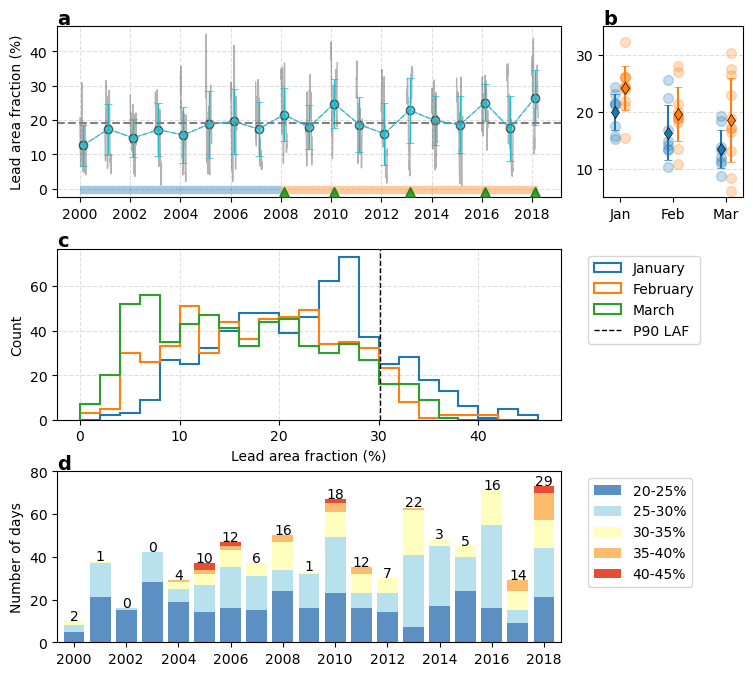

In [7]:
# Combined plot

fig = plt.figure(figsize=(7,8), constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=4, left=0.01, right=0.99,
                        wspace=0.3, hspace=0.3)
ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1])
ax3 = fig.add_subplot(gs[1, :-1])
ax4 = fig.add_subplot(gs[2, :-1])

ax1.set_ylabel('Lead area fraction (%)') 
ax3.set_ylabel('Count') 
ax4.set_ylabel('Number of days') 

#ax2.tick_params(axis="y",direction="in", pad=-22)
#ax2.set_yticklabels([]);

plotvar = lfa_daily*100

#################
## Subplot1
#################

start_date = dt.datetime.strptime("2000-02-15", "%Y-%m-%d")
date_list = pd.date_range(start_date, periods=19, freq=pd.DateOffset(years=1))

ls_kw={"linewidth":0.5, "markeredgewidth":0.5, "elinewidth":1., "capsize":3, 'color':'C9'}
edgecolor = (0,0,0,0)

times=()
for y in years:
    lfa_yr = plotvar.sel(time=str(y), drop=True)
    ax1.plot(lfa_yr.time, lfa_yr, color='black', alpha=0.3, lw=1.)
    

lfa_JFMmean = plotvar.groupby('time.year').mean()  # JFM mean for each year
lfa_JFMstd = plotvar.groupby('time.year').std()    # standard deviation
lfa_clim = plotvar.mean()                          # climatological mean

ax1.plot(date_list, lfa_JFMmean, ls='--', lw=1, color='C0', marker='o', markersize=6, 
        markeredgecolor=edgecolor, markerfacecolor='C9', alpha=0.6)
ax1.errorbar(date_list, lfa_JFMmean, yerr=lfa_JFMstd, **ls_kw)

ax1.axhline(y=lfa_clim, linestyle='--', color = 'grey', zorder=2)

#################
## Subplot2
#################

# average month and year
lfa_monthly = process_data.monthly_mean_by_year(plotvar)

y1 = lfa_monthly.sel(time_level_0=slice(2000,2007)) # period 1
y2 = lfa_monthly.sel(time_level_0=slice(2008,2018)) # period 2

months = [1,2,3]
labels=['Jan', 'Feb', 'Mar']
colors = ["C0", "C1"]
width=0.1
for i, l in enumerate(months):
    y = lfa_monthly.sel(time_level_1=l).values
    yy1 = y1.sel(time_level_1=l).values# years 2000-2007
    yy2 = y2.sel(time_level_1=l).values# years 2008-2018
    
    x1 = np.ones(yy1.shape[0])*i - (width)
    x2 = np.ones(yy2.shape[0])*i + (width)
    
    s1=ax2.scatter(x1, yy1, color=colors[0], s=50, alpha=.25, zorder=1, label='2000-2007')
    s2=ax2.scatter(x2, yy2, color=colors[1], s=50, alpha=.25, zorder=1, label='2008-2018')
   
    yy1mean = yy1.mean(); yy1std = yy1.std() 
    yy2mean = yy2.mean(); yy2std = yy2.std()
    
    ls_kw={'marker':'d', 'markersize':6, "linestyle":"none", 'markeredgecolor':(0,0,0,0.95), 
           "linewidth":1, "markeredgewidth":0.5, "elinewidth":1.5, "capsize":3}
    
    ax2.errorbar(i-width, yy1mean, yerr=yy1std ,color=colors[0], **ls_kw)
    ax2.errorbar(i+width, yy2mean, yerr=yy2std ,color=colors[1], **ls_kw)
    
    # add legend
    #if i==0:
    #    ax1.legend(bbox_to_anchor=(1.04, 1.02), loc='lower right',
    #                  ncols=2, handletextpad=0.1, frameon=True)

        
#################
## Subplot3
#################
bins = np.arange(0,45+2,2)
_, ax3 = plot_hist_p90(ax3, plotvar, bins=bins)
ax3.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

#################
## Subplot4
#################
laf_masked = plotvar.where(plotvar>20)
bins=[20, 25, 30, 35, 40, 45]
_,ax4 = plot_Ndays_barplot(ax4, laf_masked, bins=bins)
ax4.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

############################

# label stuff
ax1.grid(ls='--', alpha=0.4)    
ax1.set_xlabel('')
ax2.set_xticks(range(len(months)))
ax2.set_xticklabels(labels)
ax2.set_yticks([10, 20, 30])
ax2.set_ylim([5,35])
ax2.grid(axis='y', ls='--', alpha=0.4)   
ax2.margins(x=0.1)


labels = ['a', 'b', 'c', 'd']
axes = (ax1, ax2, ax3, ax4)
for ax, lab in zip(axes, labels):
    ax.text(0., 1.1, lab, transform=ax.transAxes,
      fontsize=14, fontweight='bold', va='top')
    
# highlight breakup years
id_yrs = date_list[date_list.year.isin([2008, 2010, 2013, 2016, 2018])]
cbargs = {'color': 'green', 'alpha': 0.5, 'zorder':3, 'marker':"^", 'markersize': 15, 'ymax':0.}
[ax1.axvline(dto, **cbargs) for dto in id_yrs]

# highlight periods
ax1.hlines(y=-0.3, xmin=plotvar.sel(time='2000')[0].time, xmax=plotvar.sel(time='2008')[0].time, linewidth=6, color=colors[0], alpha=0.4)
ax1.hlines(y=-0.3, xmin=plotvar.sel(time='2008')[0].time, xmax=plotvar.sel(time='2018')[-1].time, linewidth=6, color=colors[1], alpha=0.4)

plt.show()

fig.savefig('../figures/' + f'fig03_leadAreaFrac_climatologyJFM_{clim}_moore22_2000-2018_combined_v2.png', dpi=300, bbox_inches='tight')    


## Calculate mean and std for monthly LAFs

In [ ]:

lfa_monthly = process_data.monthly_mean_by_year(lfa_daily)*100
months = [1,2,3]
for p in ([2000,2007], [2008,2018]):
    print(f'----- Period: {p[0]}-{p[1]} ----- ')
    var = lfa_monthly.sel(time_level_0=slice(p[0],p[1])) # period 1
          
    for j, l in enumerate(months):
        tmp = var.sel(time_level_1=l).values
    
        _mean = tmp.mean() 
        _std = tmp.std() 

        print(f'Month {l} : MEAN {_mean} , STD {_std}')
